## 1.환경설정

### (1) 라이브러리 불러오기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [146]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(12, 6))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

### (2) 데이터 불러오기

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [334]:
train_data = pd.read_csv('/content/drive/MyDrive/15 Mini Project/train_dataset.csv')
train_data2 = pd.read_csv('/content/drive/MyDrive/15 Mini Project/data01_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/15 Mini Project/test_dataset.csv')

#### train_data 합치기

- WALKING : 0  
- WALKING_UPSTAIRS : 1  
- WALKING_DOWNSTAIRS : 2  
- LAYING : 3  
- STANDING : 4  
- SITTING : 5

In [335]:
train_data2.drop(['subject'], axis=1, inplace=True)
train_data2['Activity_dynamic'] = train_data2['Activity']
train_data2['Activity_dynamic'] = train_data2['Activity_dynamic'].replace({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2, 'LAYING':3, 'STANDING':4, 'SITTING':5})

In [336]:
train_data = pd.concat([train_data, train_data2], axis=0, join='inner')

#### 데이터 분리 및 train, validation 분할

In [337]:
# 데이터 분리
x = train_data.drop(['Activity', 'Activity_dynamic', 'fBodyBodyAccJerkMag-entropy()'], axis=1)
y = train_data['Activity_dynamic']

# train, validataion 분할
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=2023)

### 모델링

#### XGB

In [264]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [309]:
# 모델
model_xgb = XGBClassifier(random_state=2023, n_estimators=200)

# 학습
model_xgb.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [310]:
# 예측
y_pred_xgb = model_xgb.predict(x_val)
y_pred_xgb = le.inverse_transform(y_pred_xgb)

# 평가
print(classification_report(y_val, y_pred_xgb))
print(accuracy_score(y_val, y_pred_xgb))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       383
           1       0.97      0.99      0.98       357
           2       0.99      0.96      0.98       304
           3       0.97      0.95      0.96       442
           4       0.94      0.97      0.95       452
           5       0.93      0.92      0.93       415

    accuracy                           0.96      2353
   macro avg       0.96      0.96      0.96      2353
weighted avg       0.96      0.96      0.96      2353

0.9617509562260943


1) train_data 합침 : 0.956651083722907  -> 0.75458  
2) 변수 조절(상위 1개 제외): 0.9617509562260943 -> 0.77566   
3) 변수 조절(상위 2개 제외) : 0.9558011049723757   
4) 변수 조절(상위 3개 제외) : 0.9524011899702507  
5) max_depth=10 : 0.9515512112197195  
6) learning_rate=0.2, n_estimators=150 : 0.953251168720782  
7) n_estimators=200 : 0.9617509562260943  -> 0.77702  
8) n_estimators=300 : 0.9634509137271569  -> 0.77566  
9) n_estimators=250 : 0.9609009774755631  
10) n_estimators=200, learning_rate=0.2 : 0.9524011899702507  
11) n_estimators=200, max_depth=8 : 0.9575010624734381  
12) n_estimators=200, max_depth=10 : 0.9498512537186571  
13) n_estimators=200, max_depth=4 : 0.9549511262218444

#### lightgbm

In [381]:
import lightgbm as lgb

params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass',
    'num_class': 6,
    'metric': 'multi_logloss',
    'num_leaves': 60,
    'learning_rate': 0.05
}

import re
x_train = x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
x_val = x_val.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_val, label=y_val)

num_round = 300
model_lgb = lgb.train(params, train_data, num_round)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005650 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12036
[LightGBM] [Info] Number of data points in the train set: 9409, number of used features: 49
[LightGBM] [Info] Start training from score -1.763571
[LightGBM] [Info] Start training from score -1.934918
[LightGBM] [Info] Start training from score -1.996370
[LightGBM] [Info] Start training from score -1.660569
[LightGBM] [Info] Start training from score -1.698180
[LightGBM] [Info] Start training from score -1.741498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM

In [382]:
# 예측
y_pred_lgb = model_lgb.predict(x_val)
y_pred_lgb = [list(x).index(max(x)) for x in y_pred_lgb]

# 평가
print(classification_report(y_val, y_pred_lgb))
print(accuracy_score(y_val, y_pred_lgb))

              precision    recall  f1-score   support

           0       0.98      0.98      0.98       383
           1       0.97      0.98      0.98       357
           2       0.98      0.97      0.97       304
           3       0.97      0.95      0.96       442
           4       0.95      0.96      0.96       452
           5       0.94      0.94      0.94       415

    accuracy                           0.96      2353
   macro avg       0.96      0.96      0.96      2353
weighted avg       0.96      0.96      0.96      2353

0.9634509137271569


'num_leaves': 60, num_round = 300  : 0.9634509137271569  -> 0.7777  
'num_leaves': 80, num_round = 300  : 0.9558011049723757  
'num_leaves': 60, num_round = 200  : 0.9609009774755631  
'num_leaves': 60, num_round = 300, learning_rate=0.03  : 0.9609009774755631

#### catboost

In [ ]:
!pip install catboost

In [324]:
import catboost as cb

params = {
    'iterations': 100,
    'learning_rate': 0.05,
    'eval_metric': 'MultiClass',
    'loss_function': 'MultiClass',
    'random_seed': 2023
}

train_data = cb.Pool(x_train, y_train)
test_data = cb.Pool(x_val, y_val)

model = cb.CatBoostClassifier(**params)
model.fit(train_data, eval_set=test_data)

0:	learn: 1.7329877	test: 1.7341131	best: 1.7341131 (0)	total: 139ms	remaining: 13.7s
1:	learn: 1.6707248	test: 1.6716995	best: 1.6716995 (1)	total: 208ms	remaining: 10.2s
2:	learn: 1.6233815	test: 1.6250274	best: 1.6250274 (2)	total: 275ms	remaining: 8.89s
3:	learn: 1.5776151	test: 1.5794054	best: 1.5794054 (3)	total: 346ms	remaining: 8.31s
4:	learn: 1.5370109	test: 1.5396691	best: 1.5396691 (4)	total: 412ms	remaining: 7.84s
5:	learn: 1.4975560	test: 1.5005977	best: 1.5005977 (5)	total: 480ms	remaining: 7.52s
6:	learn: 1.4612155	test: 1.4644242	best: 1.4644242 (6)	total: 552ms	remaining: 7.33s
7:	learn: 1.4286846	test: 1.4320192	best: 1.4320192 (7)	total: 623ms	remaining: 7.17s
8:	learn: 1.3978006	test: 1.4018754	best: 1.4018754 (8)	total: 693ms	remaining: 7.01s
9:	learn: 1.3688768	test: 1.3728892	best: 1.3728892 (9)	total: 776ms	remaining: 6.98s
10:	learn: 1.3417881	test: 1.3462461	best: 1.3462461 (10)	total: 856ms	remaining: 6.93s
11:	learn: 1.3169003	test: 1.3213483	best: 1.3213483

In [333]:
y_pred = model.predict(x_val)

# 평가
print(classification_report(y_val, y_pred))
print(accuracy_score(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.78      0.78       383
           1       0.70      0.73      0.72       357
           2       0.78      0.74      0.76       304
           3       0.69      0.83      0.76       442
           4       0.66      0.74      0.70       452
           5       0.64      0.42      0.51       415

    accuracy                           0.71      2353
   macro avg       0.71      0.71      0.70      2353
weighted avg       0.70      0.71      0.70      2353

0.7050573735656609


#### 변수 중요도

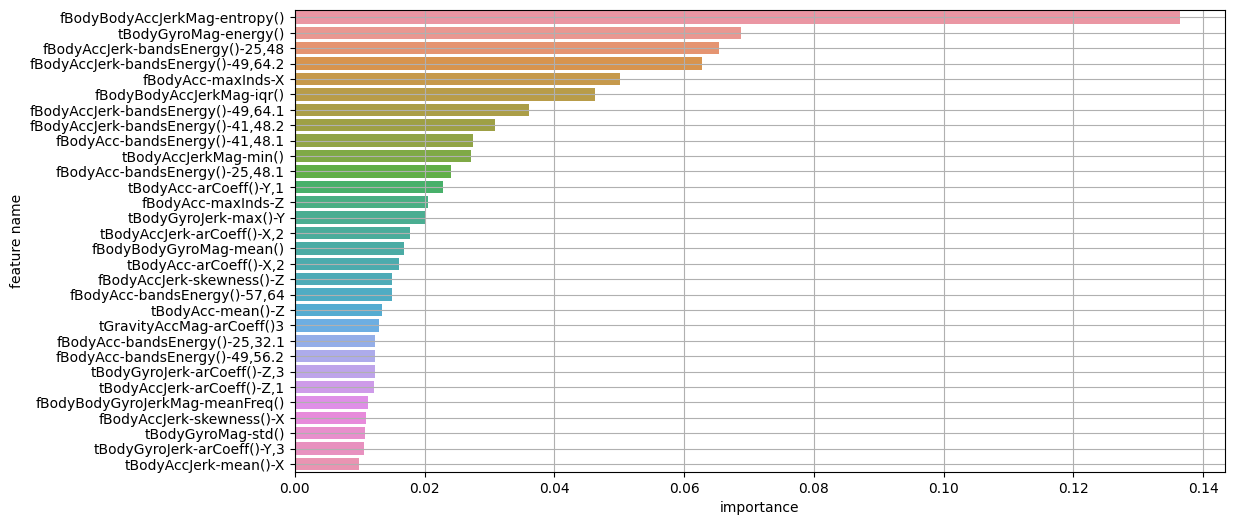

In [148]:
# 변수 중요도 추출
fi_df = plot_feature_importance(model_xgb.feature_importances_, x_train.columns, result_only=False, topn=30)

In [161]:
fi_df['feature_name']

0          fBodyBodyAccJerkMag-entropy()
1                  tBodyGyroMag-energy()
2       fBodyAccJerk-bandsEnergy()-25,48
3     fBodyAccJerk-bandsEnergy()-49,64.2
4                     fBodyAcc-maxInds-X
5              fBodyBodyAccJerkMag-iqr()
6     fBodyAccJerk-bandsEnergy()-49,64.1
7     fBodyAccJerk-bandsEnergy()-41,48.2
8         fBodyAcc-bandsEnergy()-41,48.1
9                  tBodyAccJerkMag-min()
10        fBodyAcc-bandsEnergy()-25,48.1
11                tBodyAcc-arCoeff()-Y,1
12                    fBodyAcc-maxInds-Z
13                 tBodyGyroJerk-max()-Y
14            tBodyAccJerk-arCoeff()-X,2
15               fBodyBodyGyroMag-mean()
16                tBodyAcc-arCoeff()-X,2
17             fBodyAccJerk-skewness()-Z
18          fBodyAcc-bandsEnergy()-57,64
19                     tBodyAcc-mean()-Z
20             tGravityAccMag-arCoeff()3
21        fBodyAcc-bandsEnergy()-25,32.1
22        fBodyAcc-bandsEnergy()-49,56.2
23           tBodyGyroJerk-arCoeff()-Z,3
24            tB

#### test_data

In [372]:
test_data = pd.read_csv('/content/drive/MyDrive/15 Mini Project/test_dataset.csv')

In [373]:
test_data.drop(['fBodyBodyAccJerkMag-entropy()'], axis=1, inplace=True)

In [374]:
# 예측
y_pred = model_lgb.predict(test_data)
y_pred

array([[4.00446025e-06, 4.00832204e-06, 3.66703036e-06, 1.28563438e-02,
        3.93963218e-01, 5.93168758e-01],
       [1.65736050e-08, 1.58286391e-08, 1.37796745e-08, 2.13493761e-06,
        9.99105542e-01, 8.92276499e-04],
       [9.99925856e-01, 7.03242406e-05, 1.97686270e-06, 1.06148722e-06,
        5.65230272e-07, 2.16606670e-07],
       ...,
       [6.54514066e-02, 3.06067718e-05, 9.34269180e-01, 2.11320475e-04,
        2.52028757e-05, 1.22833492e-05],
       [1.81471198e-07, 1.60004311e-07, 1.55034751e-07, 9.98346302e-01,
        9.94022276e-04, 6.59179014e-04],
       [4.87511741e-05, 4.52977232e-05, 9.99903344e-01, 4.99563151e-07,
        1.98961102e-06, 1.17737430e-07]])

In [376]:
y_pred = [list(x).index(max(x)) for x in y_pred]

In [377]:
y_pred_df = pd.DataFrame()
y_pred_df['ACtivity'] = y_pred
y_pred_df['ID'] = y_pred_df.index
y_pred_df.set_index('ID', inplace=True)
y_pred_df.head()

,ACtivity
ID,
0,5
1,4
2,0
3,5
4,4


In [378]:
y_pred_df.to_csv('/content/drive/MyDrive/15 Mini Project/y_pred1.csv')

## 단계별 모델링

#### train_data 합치기

In [213]:
train_data = pd.read_csv('/content/drive/MyDrive/15 Mini Project/train_dataset.csv')
train_data2 = pd.read_csv('/content/drive/MyDrive/15 Mini Project/data01_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/15 Mini Project/test_dataset.csv')

In [214]:
train_data2.drop(['subject'], axis=1, inplace=True)
train_data2['Activity_dynamic'] = train_data2['Activity']
train_data2['Activity_dynamic'] = train_data2['Activity_dynamic'].replace({'WALKING':0, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':2, 'LAYING':3, 'STANDING':4, 'SITTING':5})

In [215]:
train_data = pd.concat([train_data, train_data2], axis=0, join='inner')
train_data.head()

,tBodyAcc-mean()-Z,"tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-Y,1",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,"tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,3",...,fBodyGyro-min()-Y,"fBodyGyro-bandsEnergy()-49,64.1",fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyGyroMag-mean(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-meanFreq(),"angle(tBodyAccMean,gravity)",Activity,Activity_dynamic
0,-0.103362,-0.094784,-0.109208,0.068584,-0.014314,0.198600,-0.073666,0.113098,-0.058315,0.354270,...,-0.996607,-0.999969,-0.985141,-1.000000,-0.975435,-0.993965,-0.032207,-0.042494,STANDING,4
1,-0.098163,-0.052478,0.464764,0.075947,0.004456,0.130310,0.401913,0.512569,0.011987,0.503466,...,-0.992681,-0.999941,-0.988982,-1.000000,-0.978534,-0.994733,-0.246705,-0.062899,LAYING,3
2,-0.108717,-0.226718,0.301165,0.079530,0.014504,0.111340,0.263556,0.562730,0.314589,0.132061,...,-0.999971,-0.999976,-0.991535,-1.000000,-0.991953,-0.992200,0.388765,0.000265,STANDING,4
3,-0.150354,0.549363,-0.384117,-0.309509,-0.201293,0.411714,-0.372620,0.288349,-0.259441,-0.711894,...,-0.876509,-0.969331,-0.387366,0.323260,-0.479590,-0.889227,0.050888,-0.255125,WALKING,0
4,0.091229,-0.091537,-0.610793,0.584212,-0.266815,-0.248696,-0.628852,0.095282,-0.240501,-0.305964,...,-0.960097,-0.990292,-0.220963,0.446385,-0.433366,-0.810446,-0.013902,-0.044344,WALKING_DOWNSTAIRS,2


#### 정적, 동적 분류


In [216]:
train_data['is_dynamic'] = np.where((train_data['Activity'] == 'STANDING') | (train_data['Activity'] == 'SITTING') | (train_data['Activity'] == 'LAYING'), 0, 1)
train_data.head()

,tBodyAcc-mean()-Z,"tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-Y,1",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,"tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,3",...,"fBodyGyro-bandsEnergy()-49,64.1",fBodyBodyAccJerkMag-iqr(),fBodyBodyAccJerkMag-entropy(),fBodyBodyGyroMag-mean(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-meanFreq(),"angle(tBodyAccMean,gravity)",Activity,Activity_dynamic,is_dynamic
0,-0.103362,-0.094784,-0.109208,0.068584,-0.014314,0.198600,-0.073666,0.113098,-0.058315,0.354270,...,-0.999969,-0.985141,-1.000000,-0.975435,-0.993965,-0.032207,-0.042494,STANDING,4,0
1,-0.098163,-0.052478,0.464764,0.075947,0.004456,0.130310,0.401913,0.512569,0.011987,0.503466,...,-0.999941,-0.988982,-1.000000,-0.978534,-0.994733,-0.246705,-0.062899,LAYING,3,0
2,-0.108717,-0.226718,0.301165,0.079530,0.014504,0.111340,0.263556,0.562730,0.314589,0.132061,...,-0.999976,-0.991535,-1.000000,-0.991953,-0.992200,0.388765,0.000265,STANDING,4,0
3,-0.150354,0.549363,-0.384117,-0.309509,-0.201293,0.411714,-0.372620,0.288349,-0.259441,-0.711894,...,-0.969331,-0.387366,0.323260,-0.479590,-0.889227,0.050888,-0.255125,WALKING,0,1
4,0.091229,-0.091537,-0.610793,0.584212,-0.266815,-0.248696,-0.628852,0.095282,-0.240501,-0.305964,...,-0.990292,-0.220963,0.446385,-0.433366,-0.810446,-0.013902,-0.044344,WALKING_DOWNSTAIRS,2,1


#### 데이터 분리 및 train, validation 분할

In [217]:
# 데이터 분리
x = train_data.drop(['Activity', 'Activity_dynamic', 'is_dynamic', 'fBodyBodyAccJerkMag-entropy()'], axis=1)
y = train_data[['Activity_dynamic', 'is_dynamic']]

# train, validataion 분할
from sklearn.model_selection import train_test_split

x_train, x_val, y_train2, y_val2 = train_test_split(x, y, test_size=0.2, random_state=2023)
y_train = y_train2['is_dynamic']
y_val = y_val2['is_dynamic']

#### 모델링

In [218]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train = le.fit_transform(y_train)

In [219]:
# 모델
model1 = XGBClassifier(random_state=2023)

# 학습
model1.fit(x_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=2023, ...)

In [220]:
# 예측
y_pred1 = model1.predict(x_val)
y_pred1 = le.inverse_transform(y_pred1)

# 평가
print(classification_report(y_val, y_pred1))
print(accuracy_score(y_val, y_pred1))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1309
           1       1.00      1.00      1.00      1044

    accuracy                           1.00      2353
   macro avg       1.00      1.00      1.00      2353
weighted avg       1.00      1.00      1.00      2353

0.9991500212494687


#### 합치기

In [221]:
model1_predict = x_val.copy()
model1_predict['is_dynamic_pred'] = y_pred1
model1_predict['Activity_dynamic'] = y_val2['Activity_dynamic']
model1_predict.head()

,tBodyAcc-mean()-Z,"tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-Y,1",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,"tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,3",...,"fBodyAccJerk-bandsEnergy()-49,64.2",fBodyGyro-min()-Y,"fBodyGyro-bandsEnergy()-49,64.1",fBodyBodyAccJerkMag-iqr(),fBodyBodyGyroMag-mean(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-meanFreq(),"angle(tBodyAccMean,gravity)",is_dynamic_pred,Activity_dynamic
4848,-0.113272,0.069785,0.232532,0.055748,0.017268,0.118931,0.269198,0.225245,0.171981,0.062439,...,-0.999610,-0.993234,-0.999480,-0.990385,-0.906562,-0.995764,0.371987,-0.090926,0,3
1587,-0.103082,-0.078854,0.291754,0.076577,0.004964,0.206716,0.389635,0.349504,0.248415,0.333350,...,-0.999549,-0.998262,-0.999970,-0.990068,-0.996085,-0.999137,0.386526,-0.018746,0,5
3582,-0.055839,0.495695,-0.499185,0.372700,-0.152437,0.328673,-0.571868,-0.268597,-0.322398,-0.036135,...,-0.959963,-0.842155,-0.989931,-0.720909,-0.637217,-0.897789,0.113706,-0.035312,1,1
3372,-0.391456,0.312787,-0.550458,0.038790,0.000188,0.035016,-0.650243,-0.470245,-0.462564,-0.008337,...,-0.988461,-0.826473,-0.957208,-0.658258,-0.492358,-0.817660,0.052462,0.190931,1,1
3294,-0.096952,0.074420,-0.090615,0.121701,0.590609,-0.014846,-0.234613,0.004938,-0.165341,0.168859,...,-0.947273,-0.849168,-0.977433,-0.254987,-0.403030,-0.873068,-0.032081,0.267264,1,0


#### 세부행동 분류


In [222]:
static_data = model1_predict[model1_predict['is_dynamic_pred'] == 0]

# 데이터 분리
x_st = static_data.drop(['is_dynamic_pred', 'Activity_dynamic'], axis=1)
y_st = static_data['Activity_dynamic']

# train, validataion 분할
from sklearn.model_selection import train_test_split

x_st_train, x_st_val, y_st_train, y_st_val = train_test_split(x_st, y_st, test_size=0.2, random_state=2023)

In [223]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_st_train = le.fit_transform(y_st_train)

In [224]:
# 모델
model2_1 = XGBClassifier(random_state=2023)

# 학습
model2_1.fit(x_st_train, y_st_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [225]:
# 예측
y_pred2_1 = model2_1.predict(x_st_val)
y_pred2_1 = le.inverse_transform(y_pred2_1)

# 평가
print(classification_report(y_st_val, y_pred2_1))
print(accuracy_score(y_st_val, y_pred2_1))

              precision    recall  f1-score   support

           3       0.77      0.80      0.78        84
           4       0.76      0.79      0.78       101
           5       0.68      0.62      0.64        78

    accuracy                           0.74       263
   macro avg       0.74      0.74      0.73       263
weighted avg       0.74      0.74      0.74       263

0.7414448669201521


In [226]:
dynamic_data = model1_predict[model1_predict['is_dynamic_pred'] == 1]

# 데이터 분리
x_dy = dynamic_data.drop(['is_dynamic_pred', 'Activity_dynamic'], axis=1)
y_dy = dynamic_data['Activity_dynamic']

# train, validataion 분할
from sklearn.model_selection import train_test_split

x_dy_train, x_dy_val, y_dy_train, y_dy_val = train_test_split(x_dy, y_dy, test_size=0.2, random_state=2023)

In [227]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_dy_train = le.fit_transform(y_dy_train)

In [228]:
# 모델
model2_2 = XGBClassifier(random_state=2023)

# 학습
model2_2.fit(x_dy_train, y_dy_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [229]:
# 예측
y_pred2_2 = model2_2.predict(x_dy_val)
y_pred2_2 = le.inverse_transform(y_pred2_2)

# 평가
print(classification_report(y_dy_val, y_pred2_2))
print(accuracy_score(y_dy_val, y_pred2_2))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        77
           1       0.73      0.85      0.79        72
           2       0.84      0.78      0.81        60

    accuracy                           0.80       209
   macro avg       0.81      0.80      0.80       209
weighted avg       0.81      0.80      0.80       209

0.8038277511961722


In [230]:
model2_1_predict = x_st_val.copy()
model2_1_predict['ACtivity'] = y_pred2_1

model2_2_predict = x_dy_val.copy()
model2_2_predict['ACtivity'] = y_pred2_2
model2_2_predict

,tBodyAcc-mean()-Z,"tBodyAcc-arCoeff()-X,2","tBodyAcc-arCoeff()-Y,1",tBodyAccJerk-mean()-X,tBodyAccJerk-mean()-Y,"tBodyAccJerk-arCoeff()-X,2","tBodyAccJerk-arCoeff()-Y,1","tBodyAccJerk-arCoeff()-Y,3","tBodyAccJerk-arCoeff()-Z,1","tBodyGyro-arCoeff()-Z,3",...,"fBodyAccJerk-bandsEnergy()-41,48.2","fBodyAccJerk-bandsEnergy()-49,64.2",fBodyGyro-min()-Y,"fBodyGyro-bandsEnergy()-49,64.1",fBodyBodyAccJerkMag-iqr(),fBodyBodyGyroMag-mean(),fBodyBodyGyroJerkMag-min(),fBodyBodyGyroJerkMag-meanFreq(),"angle(tBodyAccMean,gravity)",ACtivity
1104,-0.118575,0.057654,-0.210489,0.177882,-0.151010,-0.184729,-0.218155,0.388198,-0.263107,0.081280,...,-0.969073,-0.966421,-0.890710,-0.985741,-0.631879,-0.468381,-0.862408,-0.017602,-0.525590,1
3456,-0.040978,0.082969,-0.295236,0.111030,-0.046857,-0.000769,-0.398669,-0.135825,-0.246834,0.259105,...,-0.903513,-0.943719,-0.946957,-0.906107,-0.380285,-0.401074,-0.611788,0.613523,-0.066458,1
69,-0.140395,0.083464,-0.218768,0.024847,-0.166925,0.144366,-0.250526,0.151685,-0.149612,0.225063,...,-0.897618,-0.886900,-0.927564,-0.933181,-0.114645,-0.483007,-0.720593,-0.174470,-0.695351,0
4195,-0.127330,0.302411,-0.351038,0.177791,0.025902,0.124661,-0.439532,0.045989,-0.187542,-0.201602,...,-0.897894,-0.906318,-0.563055,-0.919556,-0.336083,-0.339513,-0.741285,0.115993,-0.527335,2
5151,-0.111546,0.455242,-0.046143,0.062475,0.056337,0.211943,-0.088837,0.275204,-0.385734,-0.265013,...,-0.955098,-0.989455,-0.906831,-0.972323,-0.509231,-0.466615,-0.671458,0.042155,-0.572849,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5018,-0.166583,0.410162,-0.331118,0.012302,0.027068,0.212244,-0.393611,-0.151724,-0.131834,-0.725512,...,-0.936554,-0.941574,-0.443572,-0.858966,-0.337576,-0.366993,-0.897051,-0.129716,-0.536059,1
3306,-0.113655,0.103626,-0.207850,-0.522727,0.147903,-0.047518,-0.232413,0.193631,0.003621,-0.174350,...,-0.857606,-0.728608,-0.933615,-0.988952,-0.394699,-0.514320,-0.792224,0.222929,-0.846827,1
2086,-0.050656,0.428424,0.064393,0.277682,0.197222,0.316961,0.045403,0.412289,0.024482,-0.029200,...,-0.883258,-0.899859,-0.877375,-0.966266,-0.144050,-0.275377,-0.771101,0.023736,-0.587161,2
4803,-0.097253,0.416792,-0.422322,0.017797,0.125933,0.328742,-0.504098,-0.439490,-0.469593,-0.146691,...,-0.974131,-0.935059,-0.930657,-0.972686,-0.401846,-0.502468,-0.962613,0.180617,-0.333184,1


In [231]:
temp_df = pd.concat([model2_1_predict, model2_2_predict], axis=0, join='outer')

y_pred_df = pd.DataFrame()
y_pred_df['ACtivity'] = temp_df['ACtivity']
y_pred_df.sort_index(ascending=True, inplace=True)
y_pred_df

,ACtivity
65,4
68,1
69,0
88,1
97,4
...,...
5833,3
5837,1
5856,5
5866,3


In [232]:
y_st_val = pd.DataFrame(y_st_val)
y_dy_val = pd.DataFrame(y_dy_val)

y_val = pd.concat([y_st_val, y_dy_val], axis=0, join='outer')
y_val.sort_index(ascending=True, inplace=True)
y_val

,Activity_dynamic
65,3
68,2
69,0
88,1
97,5
...,...
5833,5
5837,1
5856,4
5866,3


In [233]:
# 평가
print(classification_report(y_val, y_pred_df))
print(accuracy_score(y_val, y_pred_df))

              precision    recall  f1-score   support

           0       0.86      0.78      0.82        77
           1       0.73      0.85      0.79        72
           2       0.84      0.78      0.81        60
           3       0.77      0.80      0.78        84
           4       0.76      0.79      0.78       101
           5       0.68      0.62      0.64        78

    accuracy                           0.77       472
   macro avg       0.77      0.77      0.77       472
weighted avg       0.77      0.77      0.77       472

0.7690677966101694


#### test_data